In [1]:
%matplotlib inline
from matplotlib import style
# https://matplotlib.org/stable/gallery/style_sheets/fivethirtyeight.html
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect = True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

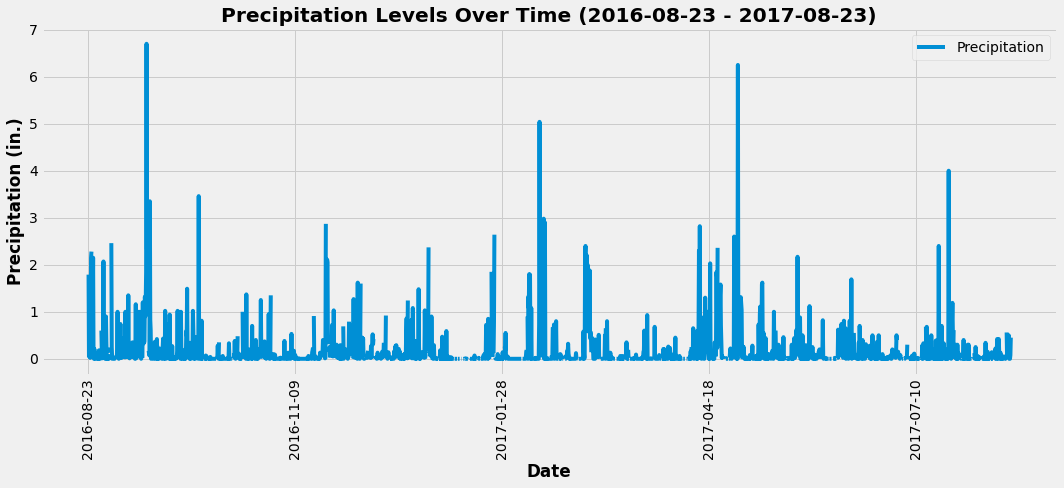

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Latest date in measurement table is 2017-08-23
# https://stackoverflow.com/questions/32334312/subtracting-n-days-from-date-in-python

# Calculate the date 1 year ago from the last data point in the database
year_minus_365 = dt.date(2017,8,23) - dt.timedelta(days=365)
latest_year = dt.date(2017,8,23)

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= year_minus_365).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
results_df = pd.DataFrame(results, columns = ['Date','Precipitation'])
results_df.set_index(results_df['Date'], inplace = True)
# results_df - check = OK

# Sort the dataframe by date
results_df = results_df.sort_index()

# Use Pandas Plotting with Matplotlib to plot the data
fig_1 = results_df.plot(rot = 90, figsize = (15,7), x_compat = True, zorder = 3)
fig_1.set_xlabel("Date", fontweight = 'bold')
fig_1.set_ylabel("Precipitation (in.)", fontweight = 'bold')
fig_1.set_title(f"Precipitation Levels Over Time ({year_minus_365} - {latest_year})", fontweight = 'bold')
fig_1.grid(zorder = 0)
plt.tight_layout()
plt.savefig('../Images/Precipitation Levels Over Time.png')
plt.show()

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
results_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [12]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Station.station).count()
print(f"There are {station_count} stations in this dataset")

There are 9 stations in this dataset


In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
sel = [Measurement.station, func.count(Measurement.id)]
most_active_stations = session.query(*sel).group_by(Measurement.station).order_by(func.count(Measurement.id).desc()).all()
most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
# define sel as the variables needed and filter by first result in most_active_stations
sel = [func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)]
most_active_station_data = session.query(*sel).group_by(Measurement.station).order_by(func.count(Measurement.id).desc()).first()
most_active_station_data
print(f"The most active station was {(most_active_stations[0])[0]}.\
    \nThe minimum teperature recorded was {most_active_station_data[0]}.\
    \nThe maximum temperature recorded was {most_active_station_data[1]}.\
    \nThe average temperature recorded was {most_active_station_data[2] : ,.1f}")

The most active station was USC00519281.    
The minimum teperature recorded was 54.0.    
The maximum temperature recorded was 85.0.    
The average temperature recorded was  71.7


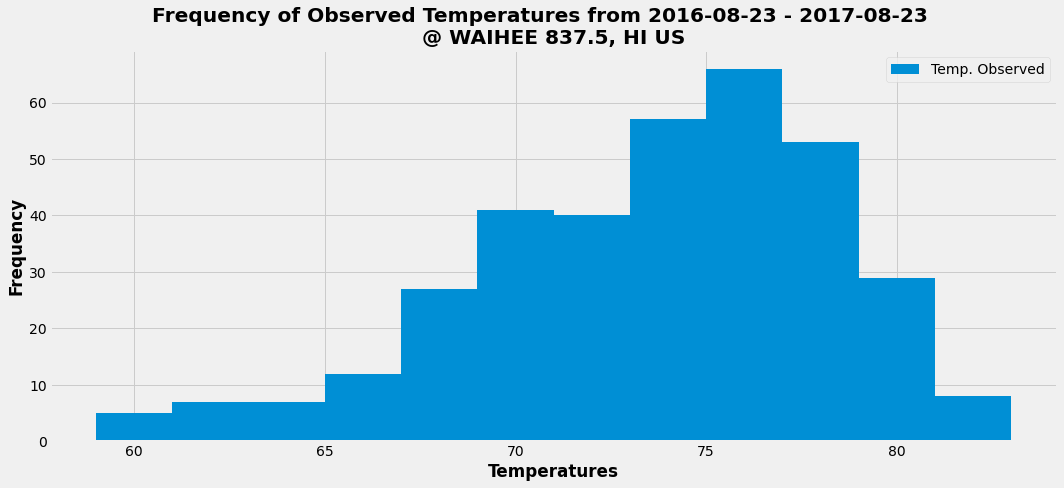

In [15]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
ss_result = session.query(Measurement.tobs).filter(Measurement.station == most_active_stations[0][0]).filter(Measurement.date >= year_minus_365).all()
temperatures = list(np.ravel(ss_result))
# len(temperatures)

# Place station table into a DF.
sel = [Station.station,Station.name,Station.latitude,Station.longitude,Station.elevation]
queryresult = session.query(*sel).all()
stations_desc = pd.DataFrame(queryresult, columns=['Station','Name','Latitude','Longitude','Elevation'])
# use .loc on DF to return row which matches most_active_stations query result
stationname = stations_desc.loc[stations_desc["Station"] == most_active_stations[0][0],"Name"].tolist()[0]
# stationname returns the correct result from prior cell.
# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize = (15,7))
plt.hist(temperatures, bins = 12, rwidth = 15, label = "Temp. Observed")
plt.ylabel("Frequency", fontweight = 'bold')
plt.xlabel("Temperatures", fontweight = 'bold')
plt.title(f"Frequency of Observed Temperatures from {year_minus_365} - {latest_year}\
    \n@ {stationname}", fontweight = 'bold')
plt.grid(zorder = 0)
plt.legend()
plt.tight_layout()
plt.savefig('../Images/Frequency of Observed Temperatures @ Most Active Station.png')
plt.show()

## Bonus Challenge Assignment

In [16]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [17]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
# start of year = year_minus_365, end of year = latest_year

prev_year_start = year_minus_365 - dt.timedelta(days = 365)
prev_year_end = latest_year - dt.timedelta(days = 365)
temps_for_df = calc_temps(prev_year_start, prev_year_end)
tmin, tavg, tmax = calc_temps(prev_year_start, prev_year_end)[0]

print(f"Start of previous year date = {prev_year_start}, end of previous year end date = {prev_year_end}")
print(f"Minimum Temp = {tmin}, Average Temp = {tavg}, Maximum Temp = {tmax}")

Start of previous year date = 2015-08-24, end of previous year end date = 2016-08-23
Minimum Temp = 56.0, Average Temp = 74.43899317406144, Maximum Temp = 86.0


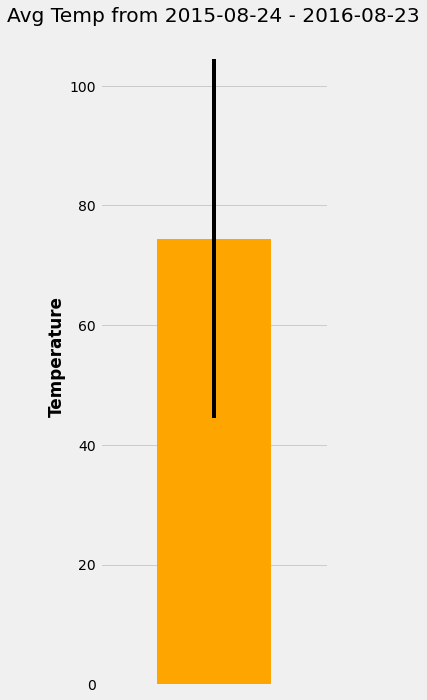

In [18]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

min_avg_max = pd.DataFrame(temps_for_df, columns =['temp_min', 'avg_temp', 'temp_max'])
# min_avg_max

yerr = min_avg_max['temp_max'] - min_avg_max['temp_min']

plt.figure(figsize = (5,10))
fig_3 = min_avg_max['avg_temp'].plot.bar(yerr = yerr, color = "orange", zorder = 3)
plt.ylabel("Temperature", fontweight = 'bold')
plt.title(f"Avg Temp from {prev_year_start} - {prev_year_end}")
plt.grid(zorder = 0)
plt.tight_layout()
plt.savefig('../Images/Average Trip Temperatures.png')
fig_3.axes.get_xaxis().set_visible(False)
plt.show()

In [19]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

sel = [Station.station, Station.name, Station.latitude, 
       Station.longitude, Station.elevation, func.sum(Measurement.prcp)]

total_rainfall_stations = session.query(*sel).\
    filter(Measurement.station == Station.station).\
    filter(Measurement.date >= prev_year_start).\
    filter(Measurement.date <= prev_year_end).\
    group_by(Station.name).order_by(func.sum(Measurement.prcp).desc()).all()
for stations in total_rainfall_stations:
    print(stations)

('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 177.55999999999997)
('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 105.70000000000006)
('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 72.25999999999999)
('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 55.51000000000001)
('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 42.35999999999999)
('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 23.78)
('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 4.5600000000000005)
('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 3.9499999999999997)
('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 0.0)


In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
# days preceeding 2017-07-10 from fig_1 appear to have low rainfall - therefore, ideal for trip?

# Set the start and end date of the trip
start_date = '2017-07-03'
end_date = '2017-07-10'

# Use the start and end date to create a range of dates
# while loop to go from start_date to end_date
# Stip off the year and save a list of %m-%d strings
# Loop through the list of %m-%d strings and calculate the normals for each date
startdtobj = dt.datetime.strptime(start_date, '%Y-%m-%d')
enddtobj = dt.datetime.strptime(end_date, '%Y-%m-%d')

trip_dates = []
normals = []
while (startdtobj <= enddtobj):
    trip_dates.append(dt.datetime.strftime(startdtobj, '%Y-%m-%d'))
    datestr = dt.datetime.strftime(startdtobj,'%m-%d')
    normals.append(list(np.ravel(daily_normals(datestr))))
    startdtobj = startdtobj + dt.timedelta(days = 1)

normals


[[68.0, 75.32075471698113, 87.0],
 [70.0, 76.57142857142857, 81.0],
 [66.0, 75.0, 81.0],
 [69.0, 75.0, 81.0],
 [69.0, 74.91071428571429, 82.0],
 [69.0, 76.08333333333333, 83.0],
 [68.0, 76.19298245614036, 83.0],
 [68.0, 75.62068965517241, 82.0]]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
this_trip = pd.DataFrame(normals, columns=['temp_min', 'temp_avg', 'temp_max'])
this_trip['Date'] = trip_dates
this_trip.set_index('Date', inplace = True)
this_trip

,temp_min,temp_avg,temp_max
Date,,,
2017-07-03,68.0,75.320755,87.0
2017-07-04,70.0,76.571429,81.0
2017-07-05,66.0,75.000000,81.0
2017-07-06,69.0,75.000000,81.0
2017-07-07,69.0,74.910714,82.0
2017-07-08,69.0,76.083333,83.0
2017-07-09,68.0,76.192982,83.0
2017-07-10,68.0,75.620690,82.0


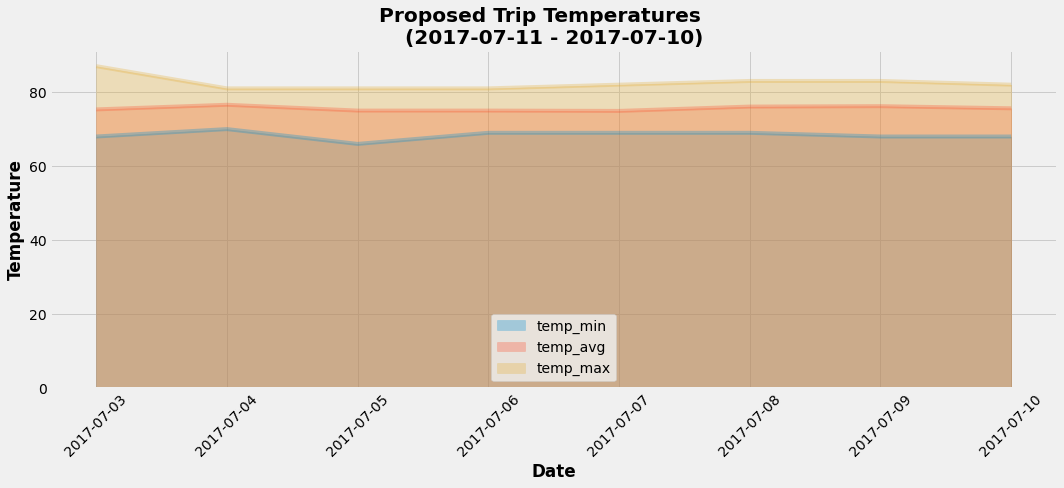

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
this_trip.plot(kind = "area", stacked = False, x_compat = True, alpha = 0.3, rot = 45, figsize = (15,7))
plt.ylabel("Temperature", fontweight = 'bold')
plt.xlabel("Date", fontweight = 'bold')
plt.title(f"Proposed Trip Temperatures\
    \n({dt.datetime.strftime(startdtobj, '%Y-%m-%d')} - {dt.datetime.strftime(enddtobj, '%Y-%m-%d')})", fontweight = 'bold')
plt.grid(zorder = 0)
plt.legend(loc = 'lower center')
plt.tight_layout()
plt.savefig('../Images/Proposed Trip Temperatures.png')
plt.show()